In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/test.csv
/kaggle/input/train.csv
/kaggle/input/gender_submission.csv


In [2]:
# get the imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
%matplotlib inline

**Data Loading**

In [3]:
#loading the dataframes with input data
# training data
input_train = pd.read_csv('/kaggle/input/train.csv')
# test data
input_test = pd.read_csv('/kaggle/input/test.csv')

**Data Analysis**

In [4]:
input_test.head()
input_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
input_train.dtypes
input_test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
input_train.isnull().sum()
input_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Dataset observations:
* There are Null values in the dataset for columns Age, Cabin and Embarked
* Columns passengerId and Ticket donot seem to affect the survival rate predictions

**Data Cleansing**

In [7]:
# Replacing NaN values with N, when cabin is unavailable
input_train.Cabin.fillna("N", inplace=True)
input_test.Cabin.fillna("N", inplace=True)
# the number of missing values for column Embarked is 2, drop these observations from the dataset
input_train.drop( input_train[ input_train['Embarked'].isnull() ].index , inplace=True)
# Replace age null values by median age for the class
grouped_df_train = input_train.groupby(['Sex','Pclass']) 
grouped_df_test = input_test.groupby(['Sex', 'Pclass'])
grouped_df_train.Age.median()
grouped_df_test.Age.median()
input_train.Age = grouped_df_train.Age.apply(lambda x: x.fillna(x.median()))
input_test.Age = grouped_df_test.Age.apply(lambda x: x.fillna(x.median()))
# sanity check on null values in the dataset
#input_train.isnull().sum()

**Feature Engineering**

In [8]:
# exploring the 'Name' column to create categorical variables
#print(input_train['Name'].head())
# as seen, Name variable has a title associated with it, this can give information of the passengers and should be used as a feature
input_train['Title'] = [i.split(",")[1].split(".")[0].strip() for i in input_train['Name']]
print(input_train['Title'].head())
input_test['Title'] = [i.split(",")[1].split(".")[0].strip() for i in input_test['Name']]
print(input_test['Title'].head())

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object
0     Mr
1    Mrs
2     Mr
3     Mr
4    Mrs
Name: Title, dtype: object


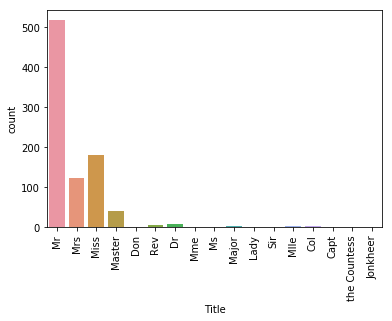

In [9]:
# plotting this new feature
title_plot = sns.countplot(x="Title",data=input_train)
title_plot = plt.setp(title_plot.get_xticklabels(), rotation = 90)

As observed above, the most frequent data values for new feature title are Mr, Mrs, Miss, Master. The other titles occur in-frequently and can be binned together into one categorical variable type. The following steps are followed for categorical binning of the Title column:
* Dictionary map with values as title and keys as numbers
* Title value 'other' assigned to infrequent values of title column

In [10]:
# binning the title values for test and train data
# o -> young male, 1 -> young female, 1 -> adult male, 2 -> adult female, 3 -> rare title
input_train['Title'] = input_train['Title'].replace(['Don','Rev', 'Dr', 'Major', 'Col', 'Capt', 'the Countess','Jonkheer'], 'Other')
input_train['Title'] = input_train['Title'].map({"Master":0, "Miss":1, "Mme":1, 'Ms':1, "Mlle":1, "Mrs":3, "Mr":2, 'Lady':3,'Sir':2, "Other":3})

input_test['Title'] = input_test['Title'].replace(['Don','Rev', 'Dr', 'Major', 'Col', 'Capt', 'the Countess','Jonkheer'], 'Other')
input_test["Title"] = input_test["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":3, "Mr":2, 'Lady':3,'Sir':2, "Other":2})


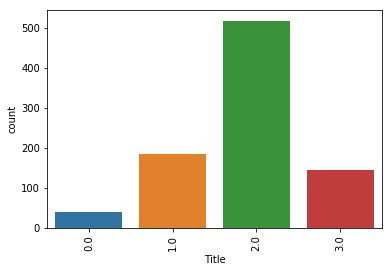

In [11]:
# Distribution of the title feature
title_plot = sns.countplot(x="Title",data=input_train)
title_plot = plt.setp(title_plot.get_xticklabels(), rotation = 90)
#print(input_train['Title'].count())

title_plot = sns.countplot(x="Title",data=input_test)
title_plot = plt.setp(title_plot.get_xticklabels(), rotation = 90)
#print(input_test['Title'].count())

In [12]:
# Two features -> SibSp, which denotes sibling and Parch -> which denotes parents/children can be combined to form a feature 'family'
# formula -> sibSp+Parch+1(individual)
input_train['Family'] = input_train['SibSp'] + input_train['Parch'] + 1
input_test['Family'] = input_test['SibSp'] + input_test['Parch'] + 1


**Data Visualization**

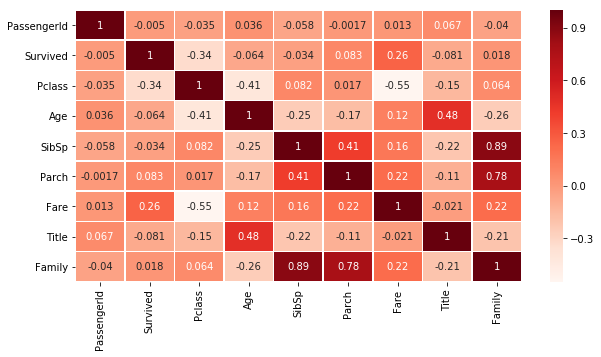

In [13]:
# visualizing the correlation between all the input variables and the probability of survival
input_train['Survived_Dead'] = input_train['Survived'].apply(lambda x : 'Survived' if x == 1 else 'Dead')
plt.figure(figsize= (10,5))
sns.heatmap(input_train.corr(),annot=True, linewidth = 0.5, cmap='Reds')

As seen above, passenger_id has low correlation with survival and can be dropped from the features. Similarly, object datatype Ticket isnt a useful feature for modeling. As 'title' column is extracted from 'name'. This column can be dropped from the input to the model

In [14]:
input_train.drop([ 'Ticket', 'Name'], axis=1, inplace = True)
input_test.drop(['Ticket', 'Name'], axis=1, inplace = True)

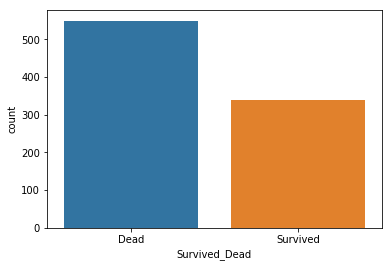

In [15]:
# Visualizing pclass,sex, embarked columns with survival
sns.countplot('Survived_Dead', data = input_train)

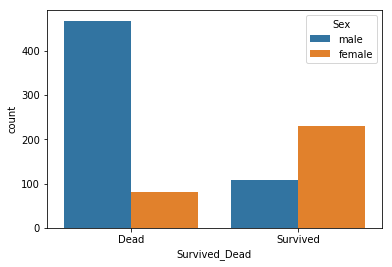

In [16]:
sns.countplot('Survived_Dead', hue = 'Sex', data = input_train)

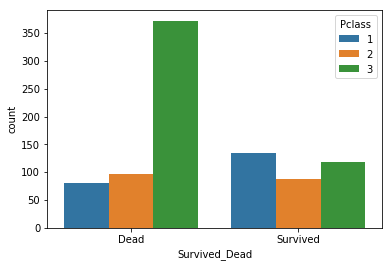

In [17]:
sns.countplot('Survived_Dead', hue = 'Pclass', data = input_train)

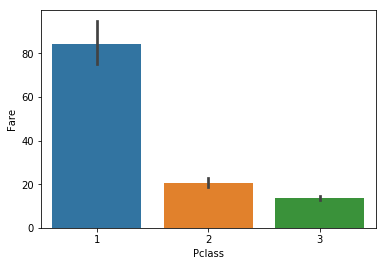

In [18]:
sns.barplot(x = 'Pclass', y = 'Fare', data = input_train)

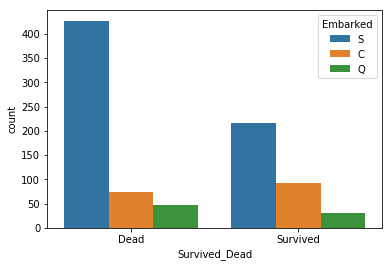

In [19]:
sns.countplot('Survived_Dead', hue = 'Embarked', data = input_train)

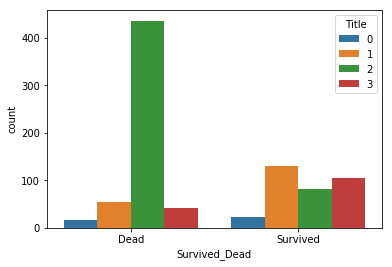

In [20]:
sns.countplot('Survived_Dead', hue = 'Title', data = input_train)

**Outlier detection**

In [21]:
# detecting the outliers in the numeric variables -> Parch, SibSp, Fare, Age
#sns.boxplot(x= input_train['Age'])
from collections import Counter
def delete_outliers(input_df, feature):
    Q1 = np.percentile(input_df[feature],25)
    Q3 = np.percentile(input_df[feature],75)
    IQR = Q3 - Q1
    step = 1.5*IQR
    indexes = input_df[(input_df[feature] < Q1 - step) | (input_df[feature] > Q3 + step )].index
    return indexes

index_list = []
for feature in ['Parch', 'SibSp', 'Fare', 'Age']:
    index_list.extend(delete_outliers(input_train, feature))
outliers = Counter(index_list)        
outliers_remove = list( k for k, v in outliers.items() if v > 2 )
print(input_train.loc[outliers_remove].head(), len(outliers_remove))


     PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch    Fare  \
27            28         0       1    male  19.0      3      2  263.00   
88            89         1       1  female  23.0      3      2  263.00   
159          160         0       3    male  25.0      8      2   69.55   
180          181         0       3  female  21.5      8      2   69.55   
201          202         0       3    male  25.0      8      2   69.55   

           Cabin Embarked  Title  Family Survived_Dead  
27   C23 C25 C27        S      2       6          Dead  
88   C23 C25 C27        S      1       6      Survived  
159            N        S      0      11          Dead  
180            N        S      1      11          Dead  
201            N        S      2      11          Dead   15


As observed above, the outliers donot seem inconsistent, caused by a data entry issue
    

**Encoding features**

In [22]:
input_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 13 columns):
PassengerId      889 non-null int64
Survived         889 non-null int64
Pclass           889 non-null int64
Sex              889 non-null object
Age              889 non-null float64
SibSp            889 non-null int64
Parch            889 non-null int64
Fare             889 non-null float64
Cabin            889 non-null object
Embarked         889 non-null object
Title            889 non-null int64
Family           889 non-null int64
Survived_Dead    889 non-null object
dtypes: float64(2), int64(7), object(4)
memory usage: 137.2+ KB


As seen above, the iput data has the following:
categorical variables:
    * Sex
    * Embarked
Number encoded variables:
    * Pclass
    * Title
Numerical variables:
    * Age
    * Fare
Other variables:
    * Family
    * Cabin

Scaling and transfromations are performed on the numerical and other variables, prior to the modeling excercise 


In [23]:
# Transforming categoricals
sex_map = {'male': 0, 'female':1}
input_train['sex_dummy'] = input_train['Sex'].map(sex_map)

sex_map = {'male': 0, 'female':1}
input_test['sex_dummy'] = input_test['Sex'].map(sex_map)

embarked_map = {'Q':0, 'C': 1, 'S': 2 }
input_train['embarked_dummy'] = input_train['Embarked'].map(embarked_map)

embarked_map = {'Q':0, 'C': 1, 'S': 2 }
input_test['embarked_dummy'] = input_test['Embarked'].map(embarked_map)


input_train.drop(['Embarked', 'Sex'], axis=1, inplace = True)
input_test.drop(['Embarked', 'Sex'], axis=1, inplace = True)

In [24]:
# Transforming numerical variables
input_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 13 columns):
PassengerId       889 non-null int64
Survived          889 non-null int64
Pclass            889 non-null int64
Age               889 non-null float64
SibSp             889 non-null int64
Parch             889 non-null int64
Fare              889 non-null float64
Cabin             889 non-null object
Title             889 non-null int64
Family            889 non-null int64
Survived_Dead     889 non-null object
sex_dummy         889 non-null int64
embarked_dummy    889 non-null int64
dtypes: float64(2), int64(9), object(2)
memory usage: 137.2+ KB


In [25]:
input_train["has_cabin"] = [0 if i == 'N'else 1 for i in input_train.Cabin]
input_test["has_cabin"] = [0 if i == 'N'else 1 for i in input_test.Cabin]

input_train.drop(['Cabin', 'Survived_Dead'], axis=1, inplace = True)
input_test.drop(['Cabin'], axis=1, inplace = True)


**Test/Train split  of the input**

In [26]:
from sklearn.preprocessing import StandardScaler
y_train = input_train['Survived']
input_train.drop(['Survived'], axis=1, inplace = True)
X_train = input_train
X_test = input_test[input_train.columns]
# replacing the fare in test set witht the mean value 
X_test['Fare'].fillna(X_test['Fare'].mean(), inplace=True)
# replacing the Nan value with the most frequent label from the title column and changing the type to int
X_test['Title'] = X_test['Title'].fillna(0.0).astype(int)
X_test2 = X_test.copy()
X_test.drop(['PassengerId'], axis=1, inplace = True)
X_train.drop(['PassengerId'], axis=1, inplace = True)
# scaling the input to the models
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


**Models,Predictions and Accuracy**

The following algorithms are tested
    * RandomForestClassifier
    * LogisticRegression
    * SVC with linear kernal
    * GradientBoostingClassifier
    * Gausian Naive bayes 
    * Knn
    
Below are the steps followed:
1) Experiment with accurancy scores using the above mentioned models
2) Use the best accuracy model and use k-fold validation and gridcv to improve the generalizing ability of the algorithm



In [27]:
# imports for machine learning models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss

# initialize dictionary to record scores
accuracy_scores = {}

In [28]:
# Applying machine learning algorithms to the training dataset and recording the scores obtained
rfc = RandomForestClassifier(random_state = 0).fit(X_train, y_train)
accuracy_scores['RandomForestClassifier'] = rfc.score(X_train, y_train)
print('Random Forest Classifier score = {0}'.format(rfc.score(X_train, y_train)))
print('************************************************')
lr = LogisticRegression(random_state = 0).fit(X_train, y_train)
accuracy_scores['LogisticRegression'] = lr.score(X_train, y_train)
print('Logistic Regression score = {0}'.format(lr.score(X_train, y_train)))
print('************************************************')
svc = SVC(random_state = 0, kernel = 'rbf').fit(X_train, y_train)
accuracy_scores['SVC_radial_basis'] = svc.score(X_train, y_train)
print('SVC radial basis score = {0}'.format(svc.score(X_train, y_train)))
print('************************************************')
knn = KNeighborsClassifier(n_neighbors = 3).fit(X_train, y_train)
accuracy_scores['KNeighborsClassifier'] = knn.score(X_train, y_train)
print('KNeighbors Classifier score = {0}'.format(knn.score(X_train, y_train)))
print('************************************************')
gnb = GaussianNB().fit(X_train, y_train)
accuracy_scores['GaussianNB'] = gnb.score(X_train, y_train)
print('GaussianNB score = {0}'.format(gnb.score(X_train, y_train)))
print('************************************************')

Random Forest Classifier score = 0.9752530933633295
************************************************
Logistic Regression score = 0.813273340832396
************************************************
SVC radial basis score = 0.8447694038245219
************************************************
KNeighbors Classifier score = 0.8728908886389202
************************************************
GaussianNB score = 0.7997750281214848
************************************************


As observed from the accuracy scores above, the highest accuracy on training data is obtained using the Random Forest Classifier.However, the model might have overfit the training data. To avoid overfitting,in the next step, k-fold validation and gridcv is used to improve the generalizing capability of the model. 

**K-fold Validation**

In [29]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
k_fold = StratifiedKFold(n_splits=3)

**Hyperparameter tuning**

The following steps are followed to test the tuning paramters for randomforest classifier:
1) Random search is used to get the most optimised set of parameters 
2) Using the narrowed down parameters from randomsearch, grid search is executed to get an optimised algorithm

In [30]:
from sklearn.model_selection import RandomizedSearchCV

# parameters in randomforest classifier
rf = RandomForestClassifier(random_state = 0)
print(rf.get_params())

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 10)]
max_features = ['auto','sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = k_fold, verbose=2, random_state=0, n_jobs = -1)

rf_random.fit(X_train, y_train)

print('Random Forest Classifier with random search best estimator:')
print(rf_random.best_params_)
print('************************************************')
print('Random Forest Classifier with random search score = {0}'.format(rf_random.best_score_))


{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.6min finished


Random Forest Classifier with random search best estimator:
{'n_estimators': 894, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}
************************************************
Random Forest Classifier with random search score = 0.8323959505061868


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Using the best estimator parameters from above, gridsearch paramter dictionary is constructed.

In [31]:
# creating a parameter grid
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60, 70, 80, 90, 100],
    'max_features': ['sqrt'],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [800, 1000, 1200],
    'criterion' : ['gini']
}

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = k_fold,  scoring="accuracy", n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

print('Random Forest Classifier with grid search best estimator:')
print(grid_search.best_params_)
print('************************************************')
print('Random Forest Classifier with grid search score = {0}'.format(grid_search.best_score_))


Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:  5.9min finished


Random Forest Classifier with grid search best estimator:
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 800}
************************************************
Random Forest Classifier with grid search score = 0.8335208098987626


As observed above, the accuracy score of gridsearch with randomforestclassifier is slightly higher than the randomsearch with randomforestclassifier. Hence, the former approach is used for submission.

**Submission**

In [32]:
# using the classifier above to predict survival rate and submitting the results
y_pred = grid_search.predict(X_test)
submission = pd.DataFrame({
        "PassengerId": X_test2["PassengerId"],
        "Survived": y_pred
    })

submission.to_csv('submission.csv', index=False)